# Assignement 1

GitHub: https://github.com/Afonso-Duarte/Intelligent-Systems-Project.git

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Regression Problem 

### Data Loading and Preparation

The first step imported essential libraries for data handling, fuzzy modeling, and visualization, including sklearn, numpy, pandas, matplotlib, torch, and skfuzzy. The diabetes dataset from sklearn.datasets was loaded, and the features and target values were separated. The dataset was then split into training and testing sets with an 80/20 ratio, ensuring a robust evaluation of model performance. Feature scaling was applied using StandardScaler to normalize the data, which is crucial for distance-based models and gradient-based optimizers, preventing certain features from dominating due to scale differences.

In [2]:
#Load Dataset 
diabetes = datasets.load_diabetes(as_frame = True)
X = diabetes.data.values
y = diabetes.target.values

diabetes.frame.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

### Clustering Parameters

Fuzzy C-means clustering was performed with two clusters and a fuzziness parameter of 2. Clustering quality was assessed using the Fuzzy Partition Coefficient (FPC), which yielded a value of 0.856, indicating good cluster separation. Preliminary tests with a higher number of clusters resulted in lower FPC values, suggesting that two clusters provided the most distinct partitioning of the data. The algorithm was configured with a convergence tolerance of 0.005 and a high iteration limit of 1000 to ensure convergence to a stable solution.

In [5]:
# Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp= np.concatenate([Xtr, ytr.reshape(-1,1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)# Hard clustering from fuzzy membership

# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

Fuzzy partition coefficient (FPC): 0.8556220811377226


To visualize the clustering results, the data were converted into a pandas DataFrame and plotted using a pairplot with cluster labels as the hue. This allowed for inspection of the feature distributions and their separation across the two clusters. Some plots display a binary-like pattern, which is expected because certain features, such as sex, are categorical variables encoded numerically. These plots confirm that the clustering meaningfully captures differences related to these features.

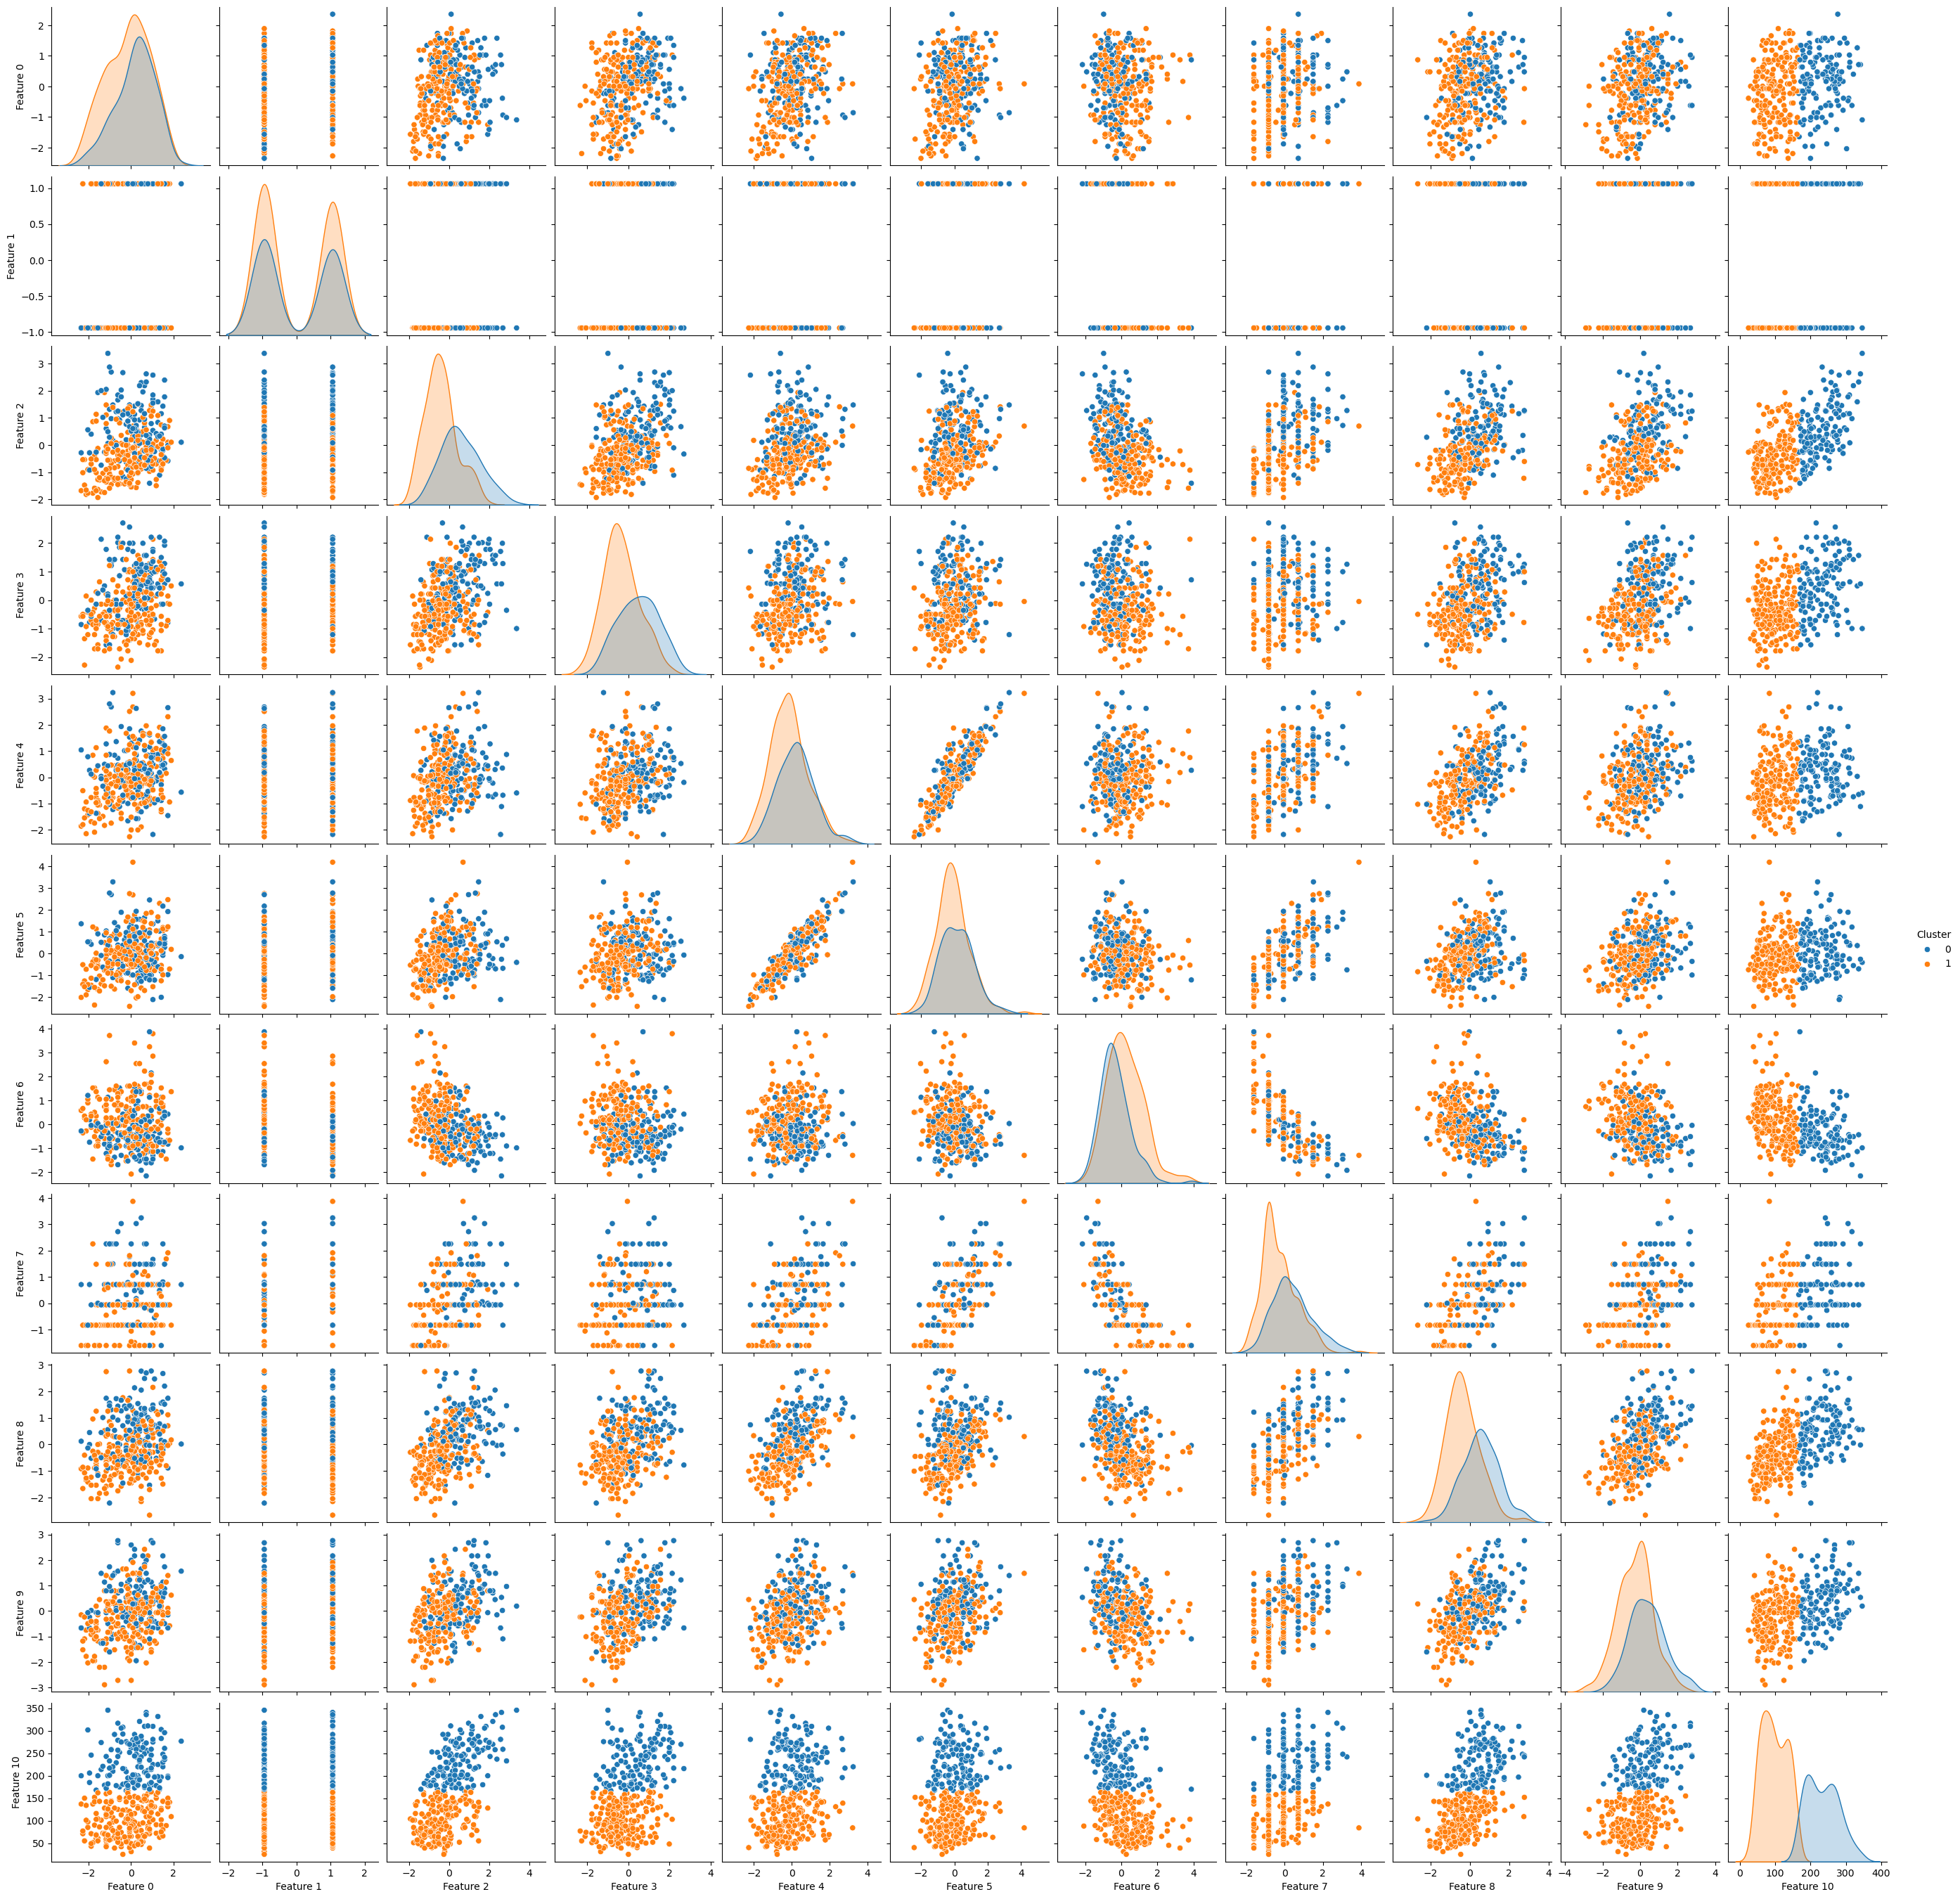

In [7]:
cluster_labels = np.argmax(u, axis=0)  

# Turn Xexp into a dataframe for plotting
df = pd.DataFrame(Xexp, columns=[f"Feature {i}" for i in range(Xexp.shape[1])])
df["Cluster"] = cluster_labels

# Pairplot with hue = cluster
sns.pairplot(df, vars=df.columns[:-1], hue="Cluster", palette="tab10", diag_kind="kde")
plt.show()

The Gaussian curves represent the membership functions of the two clusters projected onto Feature 1. Each curve is centered at the cluster mean (μ) with a spread defined by the corresponding σ, providing an interpretable visualization of how strongly samples belong to each cluster along this feature dimension. The overlap between the curves indicates the degree of fuzziness in the cluster assignments: regions with higher overlap correspond to samples with more ambiguous memberships, whereas well-separated peaks indicate clearer cluster distinctions

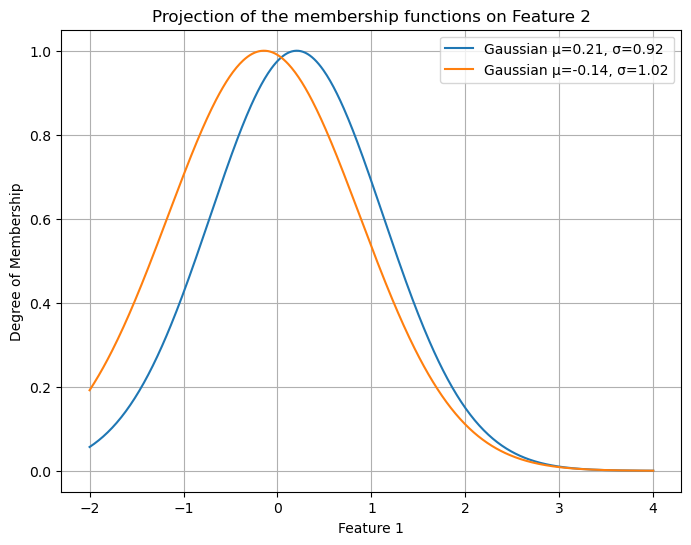

In [8]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

### Takagi–Sugeno–Kang (TSK) Fuzzy Inference Model Implementation

This section defines the core of the TSK fuzzy inference system used for the model. The GaussianMF class implements Gaussian membership functions for each rule, parameterized by learnable centers and spreads (μ and σ). The forward pass computes the degree of membership for each input sample and aggregates the distances either probabilistically (using the Euclidean norm) or using a max-based approach for stricter rule activation.

The TSK class combines these membership functions with a rule base where each rule has a set of consequent parameters forming a linear function of the inputs (plus a bias). During the forward pass, the model computes the firing strengths of each rule, normalizes them to obtain rule weights, and then performs a weighted sum of the rule outputs. This yields a smooth, differentiable mapping from input features to output predictions, making the model trainable with gradient-based optimization.

This implementation allows the TSK model to adapt both the fuzzy partitions (centers and sigmas) and the consequent parameters during training, enabling it to capture nonlinear input–output relationships while remaining interpretable.

In [9]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

### Model Training 

For optimizing the model parameters, least squares (LS) was used, where the consequents were estimated directly in closed form, while the antecedents remained fixed.

In [10]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [11]:
# Build models
LS_model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

In [12]:
#Training with LS:
train_ls(LS_model, Xtr, ytr.reshape(-1,1))

In [13]:
# Predictions
y_pred_LS, _, _ = LS_model(Xte)

# Compute MSE
mse_LS = mean_squared_error(yte.detach().numpy(), y_pred_LS.detach().numpy())

print(f"MSE LS: {mse_LS}")

MSE LS: 2545.301513671875


# Classification Problem 

For the classification task, a similar training process was followed.  
However, since the TSK fuzzy model operates on continuous outputs, it was necessary to transform the target values into binary form before training. This allowed the model to handle the problem in a regression-like framework, where the predicted continuous outputs could later be interpreted as class probabilities or thresholded into discrete labels.  

In [14]:
# Load dataset
diabetes = datasets.fetch_openml("diabetes", version=1, as_frame=True)

# Get the full DataFrame (features + target)
df = diabetes.frame

# Replace string target with binary values directly
df["class"] = df["class"].map({
    "tested_negative": 0,
    "tested_positive": 1
})

# Define X and y from the updated DataFrame
X = df.drop(columns="class").values
y = df["class"].values

print(y[:10])
df.head()

[1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Categories (2, int64): [0, 1]


preg  plas  pres  skin  insu  mass   pedi  age class
0     6   148    72    35     0  33.6  0.627   50     1
1     1    85    66    29     0  26.6  0.351   31     0
2     8   183    64     0     0  23.3  0.672   32     1
3     1    89    66    23    94  28.1  0.167   21     0
4     0   137    40    35   168  43.1  2.288   33     1

In [15]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [16]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [17]:
# Number of clusters 
n_clusters = 2
m= 1.5

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [18]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)# Hard clustering from fuzzy membership

Fuzzy partition coefficient (FPC): 0.6543559462826706


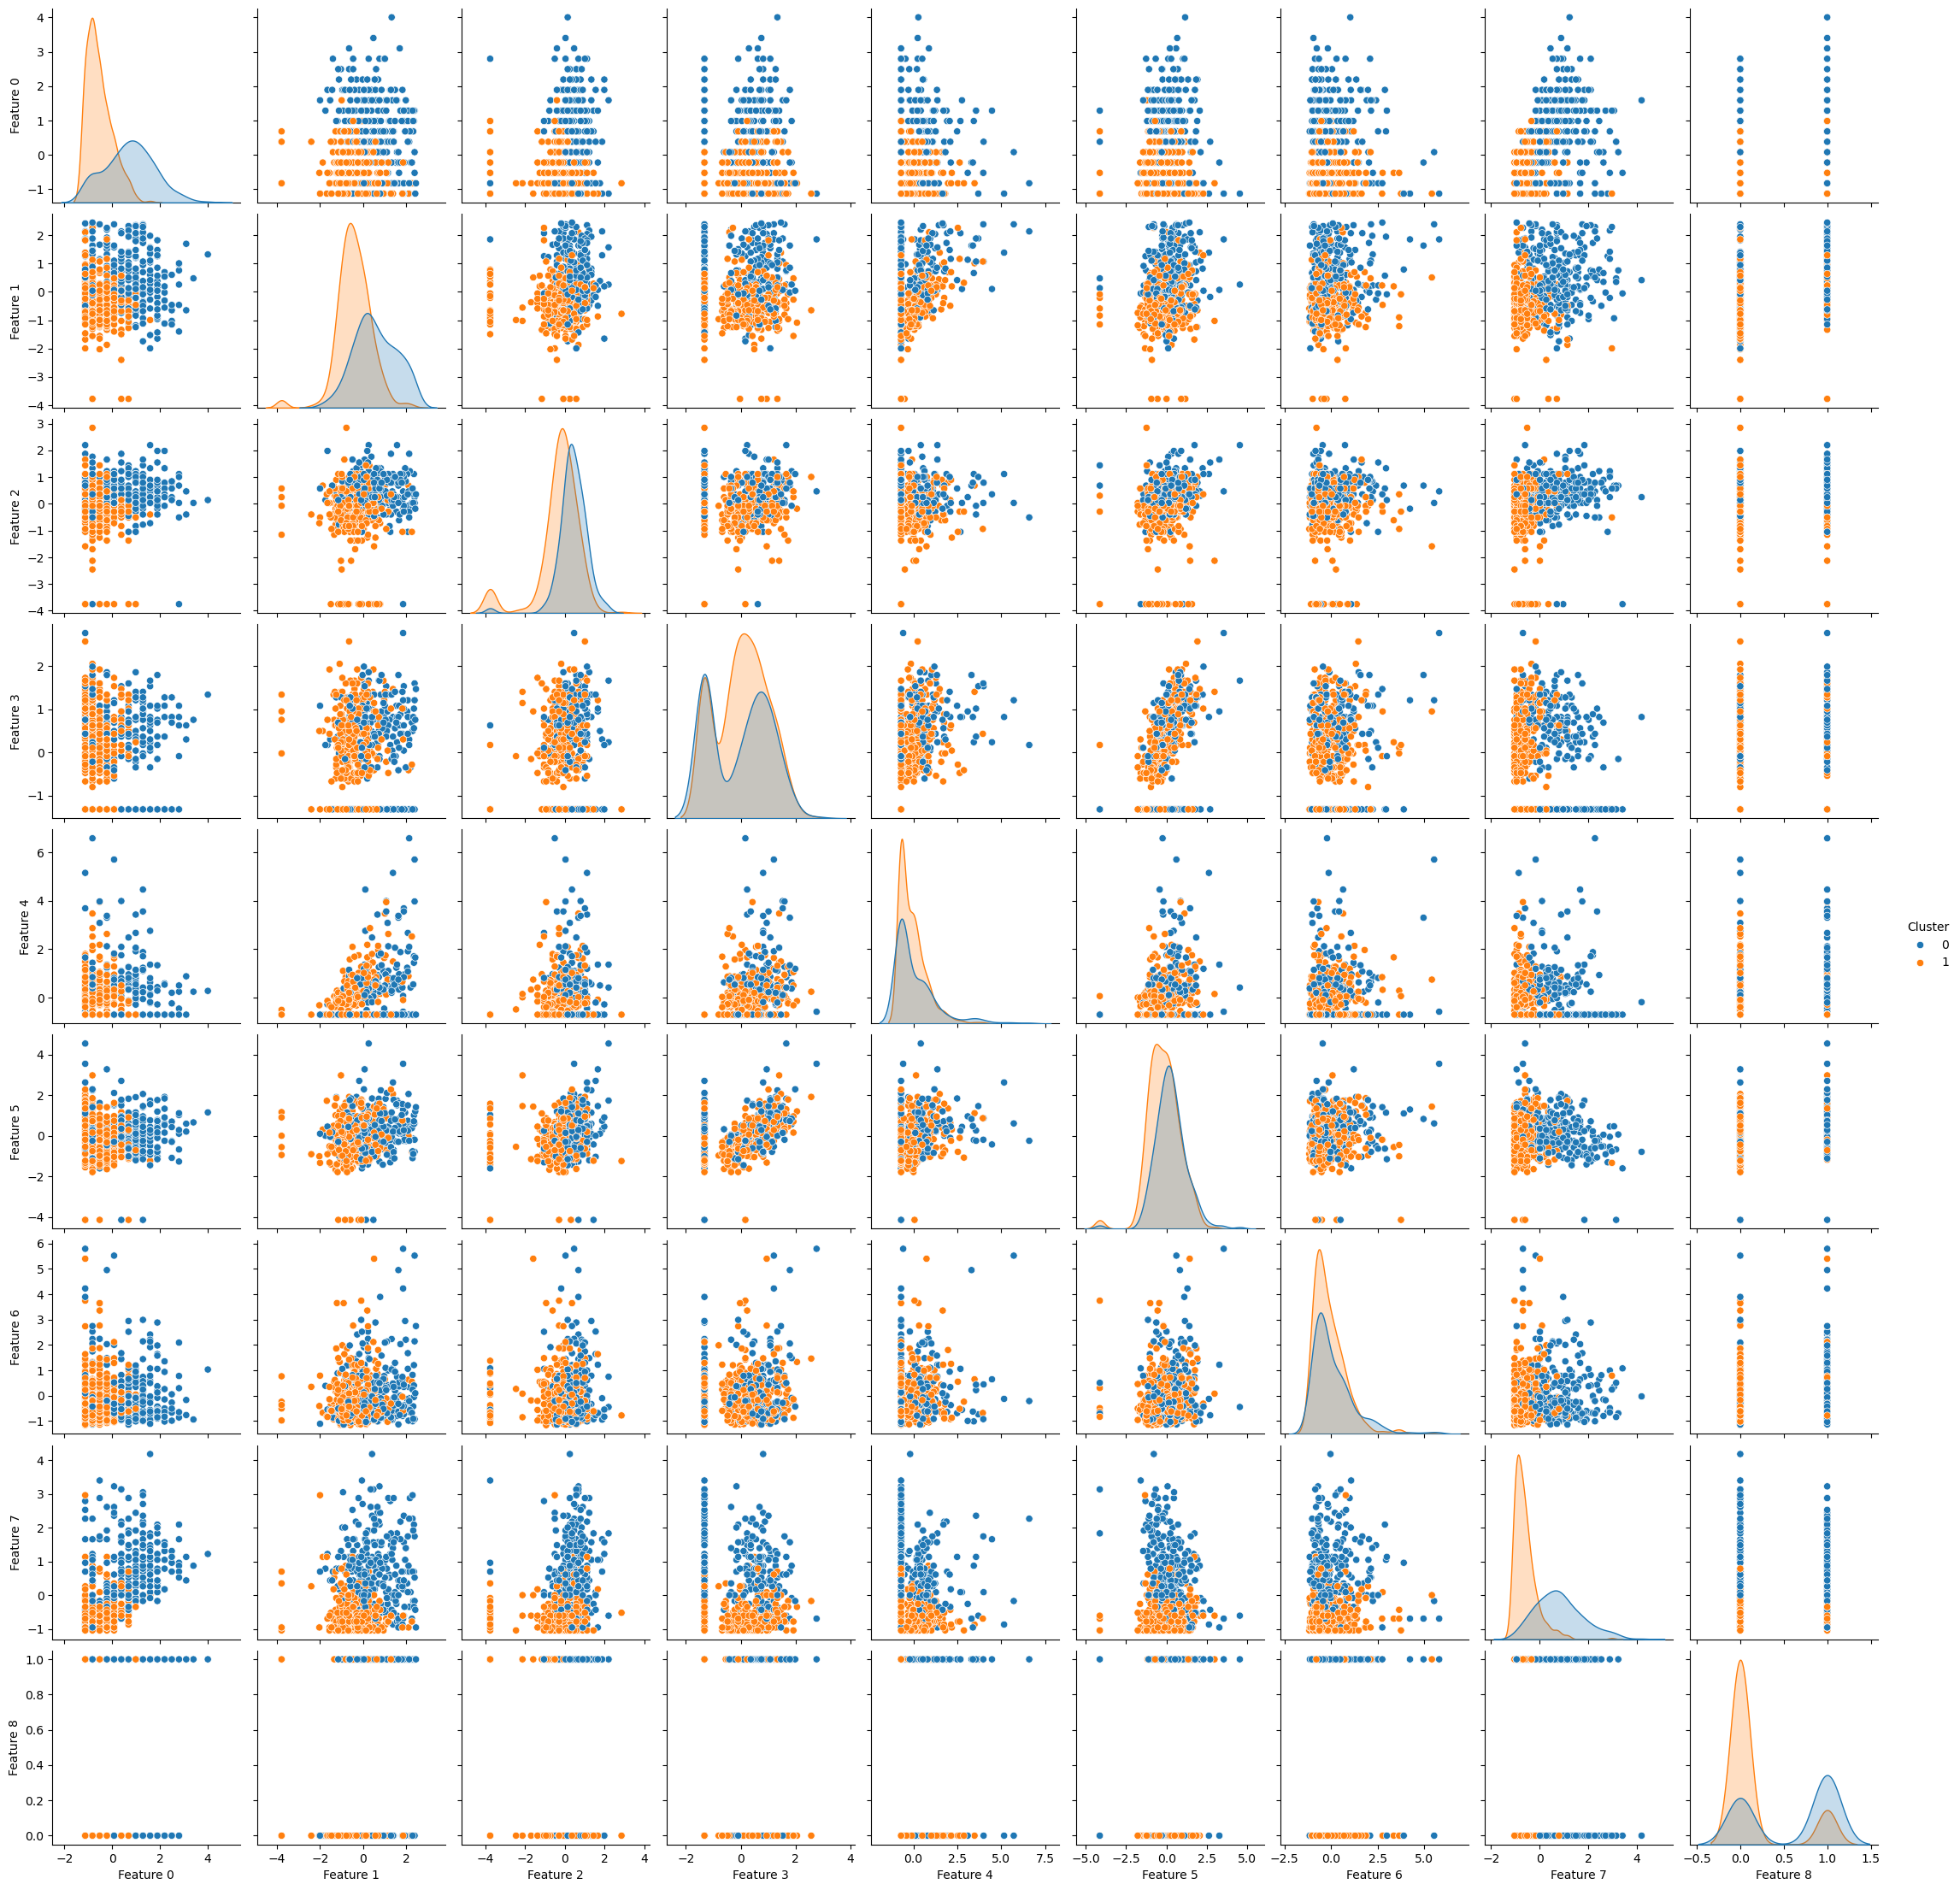

In [19]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

cluster_labels = np.argmax(u, axis=0)  

# Turn Xexp into a dataframe for plotting
df = pd.DataFrame(Xexp, columns=[f"Feature {i}" for i in range(Xexp.shape[1])])
df["Cluster"] = cluster_labels

# Pairplot with hue = cluster
sns.pairplot(df, vars=df.columns[:-1], hue="Cluster", palette="tab10", diag_kind="kde")
plt.show()

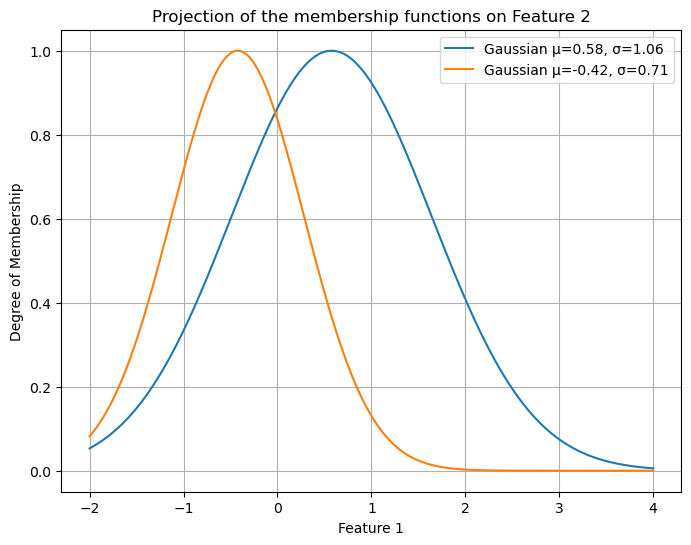

In [20]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Build models
LS_model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

In [22]:
#Training with LS:
train_ls(LS_model, Xtr, ytr.reshape(-1,1))

In [23]:
# Predictions
y_pred_LS = (LS_model(Xte)[0] >= 0.5).int()

# Compute Accuracy for each
acc_LS = accuracy_score(yte.detach().numpy(), y_pred_LS.detach().numpy())


print(f"Accuracy LS: {acc_LS:.4f}")

Accuracy LS: 0.7792
